In [1]:
#imports
import sys
import scipy.constants as con
import scipy.optimize as opt
#import scipy as sp
import numpy as np
from scipy import special
from scipy import integrate
from scipy.optimize import root_scalar

import matplotlib.pyplot as plt

import pynucastro as pyna
reaclibrary = pyna.ReacLibLibrary()

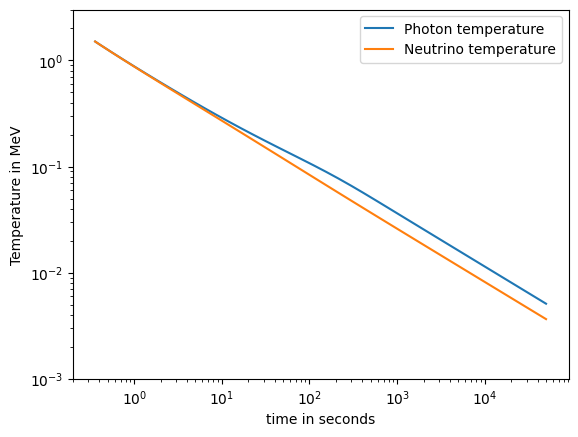

In [2]:
#Background
#Special functions og deres afledte
def L(z):
    return special.kn(2,z)/z

def M(z):
    return (3/4*special.kn(3,z)+1/4*special.kn(1,z))/z

def dMdz(z):
    return -3/z**2*special.kn(3,z) -special.kn(2,z)/z

def N(z):
    return (1/2*special.kn(4,z)+1/2*special.kn(2,z))/z


timeunit =1.519*10**21  #MeV/hbar in unit of 1/second 

n_life=879.6*timeunit   #Neutron lifetime in units of MeV/hbar
Q=1.293                 #neutron proton mass difference in MeV
M_u=931                 #atomic mass unit in MeV
SBC=np.pi**2/60         #Stefan-Boltzmann constant in natural units
G=6.709e-45             #gravatational constant in units of c=hbar=MeV=1
#infapprox=1e3           #large number acting as upper limit on itegrals
n_nu=3.046              #number of neutrino families with correction from 
                        #Nollett and Steigman, BBN and the CMB constrain neutrino coupled light WIMPs, 2015

TMeV2T9=11.60451812 #conversion factor from MeV to 10^9K
cm3s=1.167*10**-11  #conversion factor for cm^3/s
gcm3=232012         #conversion factor for g/cm^3
meter=5.068e12      #conversion factor for m
cm=5.068e10         #conversion factor for cm
barn=389.4          #conversion factor for barn
T_ini=1.5             #initial temperature in MeV
e_mass=0.51099895   #electron mass in MeV
z_ini=e_mass/T_ini

def rho_e(T): #electron/positron density, chemical potential assumed to be 0 so cosh(phi*n)=1
    z=e_mass/T
    '''
    func=lambda x: np.real(2/(np.pi**2)*e_mass**4*((x**2*(x**2-1)**0.5)/((np.exp(z*x)+1))))

    result, error = integrate.quad(func, 0, infapprox)#[0]
    return result
    '''
    return 2/np.pi**2*e_mass**4*np.sum([(-1)**(n+1)*M(n*z) for n in range(1,10)])

def drho_e(T): #derivative of rho_e with respect to temperature
    z=e_mass/T
    '''
    func=lambda x: np.real(2/(np.pi**2)*e_mass**4*((x**2*(x**2-1)**0.5)*(z*x*np.exp(z*x))/(T*(np.exp(z*x)+1)**2)))

    result, error = integrate.quad(func, 0, infapprox)#[0]
    return result
    '''
    return 2/np.pi**2*e_mass**4*np.sum([(-1)**(n)*n*z/T*dMdz(n*z) for n in range(1,10)])


def P_e(T): #electron/positron pressure
    z=e_mass/T
    '''
    func=lambda x: 2/(3*np.pi**2)*e_mass**4*((x**4*(x**2+1)**-0.5)/((np.exp(z*(x**2+1)**0.5)+1)))

    result, error = integrate.quad(func, 0, infapprox)#[0]
    return result
    '''
    #Fowler and Hoyle 1964
    #return 4/np.pi**2*T**4*np.sum([(-1)**(n+1)/n**4*special.kn(2,n*z) for n in range(1,10)])
    
    #Kawano
    return 2/np.pi**2*e_mass**4*np.sum([(-1)**(n+1)/(n*z)*L(n*z) for n in range(1,10)])  



def rho_gamma(T):   #photon energy density
    return (np.pi**2)/15*T**4 

def drho_gamma(T):  #derivative
    return 4*(np.pi**2)/15*T**3 

def P_gamma(T):     #photon pressure
    return rho_gamma(T)/3



### Initial conditions ###

n_gamma_ini= 1.20206*2/np.pi**2*T_ini**3    #initial number density of photons based on theory
n_gamma_ini= rho_gamma(T_ini)/(2.701*T_ini) #initial number density of photons based mean photon energy

eta=6.1e-10     #CMB baryon-to-photon ratio
eta_ini=eta*(1+(rho_e(T_ini)+P_e(T_ini))/(rho_gamma(T_ini)+P_gamma(T_ini))) #entropi bevarelse


rho_nu_ini=n_nu*7/8*(np.pi**2)/15*T_ini**4 #initial neutrino density

h_ini=M_u/T_ini**3*eta_ini*n_gamma_ini  #initial h

t_ini=1.226*10**21/T_ini**2 #initial time in hbar/MeV

rho_b_ini=h_ini*T_ini**3     #initial baryon density, currently set to 0

rho_tot_ini=rho_e(T_ini)+rho_gamma(T_ini)+rho_nu_ini+rho_b_ini  #initial total energy density

H_ini=np.sqrt(8*np.pi/3*G*rho_tot_ini)


def rho_nu(T,a): #neutrina energy density
    #return 7/8*np.pi**2/15*T**4
    return rho_nu_ini/a**4

def rho_b(T,h,a):
    return h_ini*T_ini**3/a**3



#def P_b(T,h):
#    return h*T**4*2/3*

#Phie_ini=np.pi**2/2*con.Avogadro*h_ini/z_ini**3*1/sum([(-1)**(n+1)*n*L(n*z_ini) for n in range(1,20)]) 




### Solving the background ###

def rho_tot(T,h,a): #total density
    return rho_e(T)+rho_gamma(T)+rho_nu(T,a)+rho_b(T,h,a)

def rho_set(T,h,a): #total density of non-decoupled components
    return rho_e(T)+rho_gamma(T)+rho_b(T,h,a)

def H(T,h,a):   #Hubble parameter as given by Friedmann eq, ignoring cosmological constant
    return np.sqrt(8*np.pi/3*G*rho_tot(T,h,a))



#Derivative from Kavano D.18
def dTdt(t,T,h,a):
    return -3*H(T,h,a)/((drho_e(T)+drho_gamma(T))/(rho_set(T,h,a) + P_e(T)+P_gamma(T)))




#dTdt(1,T_ini,h_ini,1)*timeunit

#Derivative from Kavano D.19
def dhdt(t,T,h,a):
    return -3*h*(H(T,h,a)+dTdt(t,T,h,a)/T)

#Derivative from how H is defined
def dadt(t,T,h,a):
    return a*H(T,h,a)


t_range=[t_ini,5e4*timeunit]            #time range for integration
t_space=np.linspace(*t_range,1000)      #time range for approximate temperature

#combining derivatives
def dbackground(t,y):   #solve h and T, y[0] = T, y[1] = h and y[2] = a
    return [dTdt(t,*y),dhdt(t,*y),dadt(t,*y)]



# Solving it
sol = integrate.solve_ivp(dbackground, t_range, [T_ini,h_ini,1],method='Radau')#,t_eval=t_space)

plt.figure()
# Plot the Temperature
plt.plot(sol.t/timeunit, sol.y[0], label='Photon temperature')

# Test with completely radiation dominated universe
t_space=sol.t
T_approx=np.sqrt(1.226*10**21/t_space)
#T_approx=1/np.sqrt(t_space/timeunit)/10.4*TMeV2T9
plt.plot(t_space/timeunit, T_ini/sol.y[2], label='Neutrino temperature')


#plot the scale factor
#plt.plot(sol.t/timeunit, sol.y[2]/1e3, label='scale factor')

#fix the axis
plt.xlabel('time in seconds')
plt.ylabel('Temperature in MeV')

plt.xscale('log')
plt.yscale('log')

# plt.xlim((0.1, 2e5))
plt.ylim((1e-3,3))

plt.legend()
plt.show()

#plt.figure




In [4]:
import bbn_test_integrate as bbn_n
import He4_test_integrate as He4_n


In [11]:
#Initial conditions for Y

#mass of various nuclei converted to MeV
m_n  =  1.0086649159  *M_u
m_p  =  1.00782503190 *M_u
m_d  =  2.01410177784 *M_u
m_t  =  3.01604928132 *M_u
m_He3 = 3.01602932197 *M_u
m_He4 = 4.00260325413 *M_u

#equilibrium ratios for simple rates #Pebbles
def G_np(T,a):

    N=eta_ini*n_gamma_ini/a**3 #number density
    return 4/3*(m_n*m_p*T/(2*np.pi*m_d))**1.5/N*np.exp((m_d-m_n-m_p)/T)

def G_nHe3(T):
    return 9/4*(m_d**2/(m_He3*m_n))**1.5*np.exp((m_n+m_He3-2*m_d)/T)

def G_tp(T):
    return 9/4*(m_d**2/(m_t*m_p))**1.5*np.exp((m_p+m_t-2*m_d)/T)  

def G_tp_nHe3(T):
    return ((m_He3*m_n)/(m_t*m_p))**1.5*np.exp((m_p+m_t-(m_n+m_He3))/T)

def G_nHe4(T):
    return 3*((m_d+m_t)/(m_He4*m_n))**1.5*np.exp((m_He4+m_n-m_d-m_t)/T)  

#Initial conditions
nNucs=9
Y_ini=np.zeros(nNucs)+1e-40
#Y_ini=np.array([1e-20 for i in range(nNucs)])

Xn_ini = 1/(np.exp(Q/T_ini)+1)

#Initial condition based on thermal equilibrium amongst in the most important reactions

Y_ini[0] = Xn_ini        #Set initial neutron mass fraction
Y_ini[1] = 1 - Xn_ini    #Set initial proton mass fraction
Y_ini[2] = Y_ini[0]*Y_ini[1]/G_np(T_ini,1)          #Set initial deuterium mass fraction
Y_ini[3] = Y_ini[2]**2/Y_ini[1]/G_tp(T_ini)
Y_ini[4] = Y_ini[2]**2/Y_ini[0]/G_tp_nHe3(T_ini)
Y_ini[5] = Y_ini[2]*Y_ini[3]/Y_ini[0]/G_nHe4(T_ini)

#compile rhs
bbn_n.rhs(t_ini/timeunit, Y_ini,eta_ini*n_gamma_ini*1*gcm3, T_ini*TMeV2T9*1e9)

dYdt_ini=lambda Y : bbn_n.rhs(t_ini/timeunit, Y ,eta_ini*n_gamma_ini*m_p*gcm3, T_ini*TMeV2T9*1e9)

#Find initial conditions 
Y_initial=opt.fsolve(dYdt_ini, x0=Y_ini)



#rhs(t, Y, rho, T):





In [21]:
Y_initial/sum(Y_initial)

array([ 2.95823088e-01,  7.04176912e-01,  7.91956851e-13,  3.78227691e-24,
        5.40879530e-24,  2.27329161e-31,  2.00981287e-55, -1.25370481e-57,
        6.28016457e-57])

In [12]:
#New Solving abundances

n_bparams=3
        # enumeration for different isotopes
        #  0   1   2   3    4     5     6     7     8
Y_labels=['n','p','d','t','He3','He4','Li6','Li7','Be7']
'''
step=20
print(solY.t[step]/timeunit)
print(solY.y.T[step])
initial_param=solY.y.T[step]
t_range=[solY.t[step],5e4*timeunit]
'''
initial_param=[T_ini,h_ini,1]+list(Y_ini)
t_range=[t_ini,5e4*timeunit]


def ndbackground(t,y):   #solve h and T, y[0] = T, y[1] = h and y[2] = a
    return [dTdt(t,*y),dhdt(t,*y),dadt(t,*y)]

#list(dYdt(t,y[n_bparams:],y[0],y[2]))

def ndall(t,y):   #solve h and T, y[0] = T and y[1] = h   
    #print(ndbackground(t,y[:n_bparams])+list( bbn_n.rhs(t/timeunit, y[n_bparams:],eta_ini*n_gamma_ini/y[2]**3*m_p*gcm3, y[0]*TMeV2T9*1e9)/timeunit))
                     
    return ndbackground(t,y[:n_bparams])+list( bbn_n.rhs(t/timeunit, y[n_bparams:],eta_ini*n_gamma_ini/y[2]**3*m_p*gcm3, y[0]*TMeV2T9*1e9)/timeunit)

#solY = integrate.solve_ivp(dall, [t_range[0]*0.9999, t_range[0]], [T_ini,h_ini,1]+list(Y_ini),method='RK45')#,t_eval=t_space)
#print(solY)
#solY = integrate.solve_ivp(dall, t_range, solYini.y[:,-1],method='Radau')#,t_eval=t_space)
nsolY = integrate.solve_ivp(ndall, t_range, initial_param,method='Radau',atol=1e-25,rtol=1e-4)#,t_eval=t_space)
#solY = integrate.Radau(dall, t_range[0], [T_ini,h_ini,1]+list(Y_ini),t_range[1])

abun=[abun[-1] for abun in nsolY.y[n_bparams:]]
print([abun[0],abun[1],2*abun[2],3*abun[3],3*abun[4],4*abun[5]])
print('sum: ',abun[0]+abun[1]+2*abun[2]+3*abun[3]+3*abun[4]+4*abun[5])

[7.231451771184452e-11, 0.7557053638576058, 3.7719883574401886e-05, 1.8271997825261885e-07, 2.3251200776449724e-05, 0.24423347988565414]
sum:  0.9999999976199034


In [13]:
print('Yp    = '+str(4*abun[5]/abun[1]))
print('H2/H  = '+str(2*abun[2]/abun[1]))
print('H3/H  = '+str(3*(abun[3]+abun[4])/abun[1]))
print('Li7/H = '+str(7*(abun[7])/abun[1]))
print('Li6/H = '+str(6*(abun[6])/abun[1]))
print('Be7/H = '+str(7*(abun[8])/abun[1]))

Yp    = 0.32318611401529496
H2/H  = 4.9913478689439705e-05
H3/H  = 3.100933495440677e-05
Li7/H = 2.050028925410955e-10
Li6/H = 4.364004475502568e-14
Be7/H = 3.1076730904703057e-09


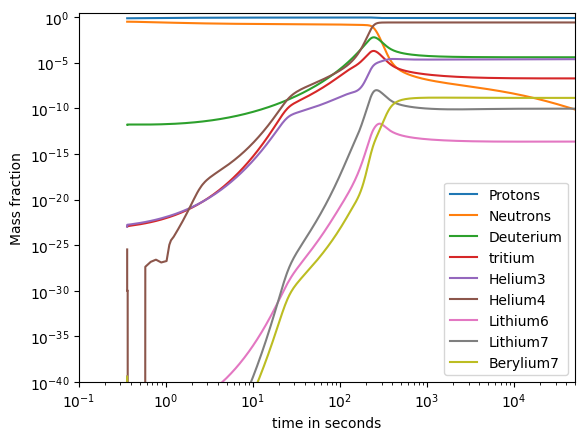

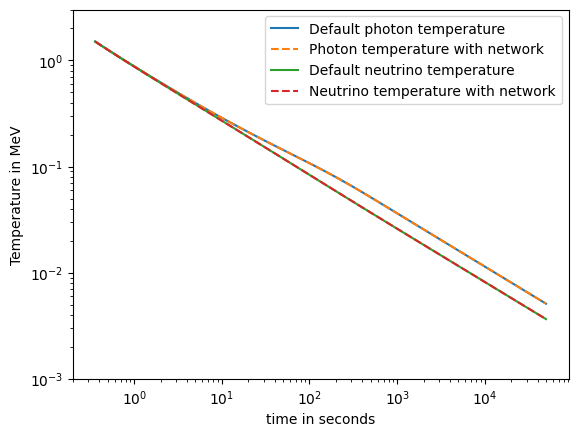

In [14]:
# Plot the results
plt.figure('abundance')
plt.plot(nsolY.t/timeunit, nsolY.y[n_bparams+1], label='Protons')
plt.plot(nsolY.t/timeunit, nsolY.y[n_bparams], label='Neutrons')
#plt.plot(solY.t/timeunit, -solY.y[n_bparams+1], label='-Neutrons')
plt.plot(nsolY.t/timeunit, 2*nsolY.y[n_bparams+2], label='Deuterium')
#plt.plot(solY.t/timeunit, -2*solY.y[n_bparams+2], label='-Deuterium')
plt.plot(nsolY.t/timeunit, 3*nsolY.y[n_bparams+3], label='tritium')
plt.plot(nsolY.t/timeunit, 3*nsolY.y[n_bparams+4], label='Helium3')
plt.plot(nsolY.t/timeunit, 4*nsolY.y[n_bparams+5], label='Helium4')
plt.plot(nsolY.t/timeunit, 4*nsolY.y[n_bparams+6], label='Lithium6')
plt.plot(nsolY.t/timeunit, 4*nsolY.y[n_bparams+7], label='Lithium7')
plt.plot(nsolY.t/timeunit, 4*nsolY.y[n_bparams+8], label='Berylium7')
#plt.plot(solY.t/timeunit, [1e-4 for t in solY.t], 'k+',label='eval test')
#plt.plot(sol.t, sol.y[3]/sol.y[2], label='n/p')

#print(solY.y[n_bparams:])
#print(solY)
plt.xlabel('time in seconds')
plt.ylabel('Mass fraction')
plt.ylim(1e-40,3)
plt.xlim(0.1,5e4)

plt.xscale('log')
plt.yscale('log')

#plt.xlim((1, 5e4))
#plt.ylim((1e-10,1.1))

plt.legend()
plt.show()

plt.figure('temperature')

# Plot the Temperature
plt.plot(sol.t/timeunit, sol.y[0], label='Default photon temperature')
plt.plot(nsolY.t/timeunit, nsolY.y[0],'--', label='Photon temperature with network')

# Test with completely radiation dominated universe
#t_space=solY.t
#T_approx=np.sqrt(1.226*10**21/t_space)
#T_approx=1/np.sqrt(t_space/timeunit)/10.4*TMeV2T9
plt.plot(sol.t/timeunit, T_ini/sol.y[2], label='Default neutrino temperature')
plt.plot(nsolY.t/timeunit, T_ini/nsolY.y[2],'--', label='Neutrino temperature with network')

#plot the scale factor
#plt.plot(sol.t/timeunit, sol.y[2]/1e3, label='scale factor')

#fix the axis
plt.xlabel('time in seconds')
plt.ylabel('Temperature in MeV')

plt.xscale('log')
plt.yscale('log')

# plt.xlim((0.1, 2e5))
plt.ylim((1e-3,3))

plt.legend()
plt.show()
